In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# install Java8
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [ ]:
# download spark3.2.0
!wget -q http://apache.osuosl.org/spark/spark-3.2.0/spark-3.2.0-bin-hadoop3.2.tgz

In [ ]:
# unzip it
!tar xf spark-3.2.0-bin-hadoop3.2.tgz


In [ ]:
# install findspark
!pip install -q findspark

In [ ]:
#Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.0-bin-hadoop3.2"

In [ ]:
 !pip install findspark

In [ ]:
#Quick Installation Test
import findspark
findspark.init()


In [ ]:
#test
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
# Test the spark
df = spark.createDataFrame([{"hello": "world"} for x in range(1000)])
df.show(3, False)

+-----+
|hello|
+-----+
|world|
|world|
|world|
+-----+
only showing top 3 rows



In [ ]:
# Check the pyspark version
import pyspark
print(pyspark.__version__)

3.2.0


In [ ]:
#know the location where Spark is installed
findspark.find()

'/content/spark-3.2.0-bin-hadoop3.2'

Loading data into PySpark

In [ ]:
df = spark.read.csv("/content/drive/MyDrive/Colab Notebooks/dataset_diabetes/diabetic_data.csv", header=True,  inferSchema=True)

In [ ]:
#Show column details
df.printSchema()


root
 |-- encounter_id: integer (nullable = true)
 |-- patient_nbr: integer (nullable = true)
 |-- race: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: string (nullable = true)
 |-- weight: string (nullable = true)
 |-- admission_type_id: integer (nullable = true)
 |-- discharge_disposition_id: integer (nullable = true)
 |-- admission_source_id: integer (nullable = true)
 |-- time_in_hospital: integer (nullable = true)
 |-- payer_code: string (nullable = true)
 |-- medical_specialty: string (nullable = true)
 |-- num_lab_procedures: integer (nullable = true)
 |-- num_procedures: integer (nullable = true)
 |-- num_medications: integer (nullable = true)
 |-- number_outpatient: integer (nullable = true)
 |-- number_emergency: integer (nullable = true)
 |-- number_inpatient: integer (nullable = true)
 |-- diag_1: string (nullable = true)
 |-- diag_2: string (nullable = true)
 |-- diag_3: string (nullable = true)
 |-- number_diagnoses: integer (nullable = true)
 |-

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import isnan, when, count, col
from pyspark.sql.functions import *
from pyspark.sql import functions as fn
from pyspark.ml import regression
from pyspark.sql.functions import countDistinct
from pyspark.sql import Row
from pyspark import sql
from pyspark.ml import feature, regression, evaluation, Pipeline
from pyspark.ml.feature import StringIndexer
from pyspark.ml import classification
from pyspark.ml.evaluation import BinaryClassificationEvaluator,MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import decimal
from pyspark.sql.types import StructType
from pyspark.sql.types import *
from pyspark.ml.feature import StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.mllib.classification import LogisticRegressionWithLBFGS
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import roc_curve, auc
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.mllib.util import MLUtils
from pyspark.mllib.evaluation import MulticlassMetrics

In [ ]:
#shape of dataframe
print((df.count(), len(df.columns)))

(101766, 50)


# **Data Cleaning and Pre-processing¶**

In [ ]:
# Getting count of missing values
df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).show()

+------------+-----------+----+------+---+------+-----------------+------------------------+-------------------+----------------+----------+-----------------+------------------+--------------+---------------+-----------------+----------------+----------------+------+------+------+----------------+-------------+---------+---------+-----------+-----------+--------------+-----------+-------------+---------+---------+-----------+------------+-------------+--------+--------+------------+----------+-------+-----------+-------+-------------------+-------------------+------------------------+-----------------------+----------------------+------+-----------+----------+
|encounter_id|patient_nbr|race|gender|age|weight|admission_type_id|discharge_disposition_id|admission_source_id|time_in_hospital|payer_code|medical_specialty|num_lab_procedures|num_procedures|num_medications|number_outpatient|number_emergency|number_inpatient|diag_1|diag_2|diag_3|number_diagnoses|max_glu_serum|A1Cresult|metformin

In [ ]:
# Getting count of null values
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show() # weight, payer_code, medical_speciality, 'citoglipton'?,'examide'?

+------------+-----------+----+------+---+------+-----------------+------------------------+-------------------+----------------+----------+-----------------+------------------+--------------+---------------+-----------------+----------------+----------------+------+------+------+----------------+-------------+---------+---------+-----------+-----------+--------------+-----------+-------------+---------+---------+-----------+------------+-------------+--------+--------+------------+----------+-------+-----------+-------+-------------------+-------------------+------------------------+-----------------------+----------------------+------+-----------+----------+
|encounter_id|patient_nbr|race|gender|age|weight|admission_type_id|discharge_disposition_id|admission_source_id|time_in_hospital|payer_code|medical_specialty|num_lab_procedures|num_procedures|num_medications|number_outpatient|number_emergency|number_inpatient|diag_1|diag_2|diag_3|number_diagnoses|max_glu_serum|A1Cresult|metformin

In [ ]:
# Dropping columns with large no of null values
drop_cols = ['weight', 'payer_code','medical_specialty']
df = df.select([column for column in df.columns if column not in drop_cols])

In [ ]:
display(df)

DataFrame[encounter_id: int, patient_nbr: int, race: string, gender: string, age: string, admission_type_id: int, discharge_disposition_id: int, admission_source_id: int, time_in_hospital: int, num_lab_procedures: int, num_procedures: int, num_medications: int, number_outpatient: int, number_emergency: int, number_inpatient: int, diag_1: string, diag_2: string, diag_3: string, number_diagnoses: int, max_glu_serum: string, A1Cresult: string, metformin: string, repaglinide: string, nateglinide: string, chlorpropamide: string, glimepiride: string, acetohexamide: string, glipizide: string, glyburide: string, tolbutamide: string, pioglitazone: string, rosiglitazone: string, acarbose: string, miglitol: string, troglitazone: string, tolazamide: string, examide: string, citoglipton: string, insulin: string, glyburide-metformin: string, glipizide-metformin: string, glimepiride-pioglitazone: string, metformin-rosiglitazone: string, metformin-pioglitazone: string, change: string, diabetesMed: str

In [ ]:
# check for duplicates in the dataset
patient_num_count = df.select('patient_nbr').groupBy('patient_nbr').count().show()

+-----------+-----+
|patient_nbr|count|
+-----------+-----+
|    2038905|    1|
|    6550191|    2|
|     300825|    3|
|    2766582|    1|
|   12254760|    2|
|    9469107|    1|
|    1655793|    1|
|   89036955|    1|
|   56526786|    1|
|    4188339|    1|
|   56039544|    1|
|   15019425|    1|
|     439650|    1|
|   17963541|    1|
|   17880444|    1|
|   25287138|    1|
|    9375993|    1|
|   23822199|    1|
|    1839672|    1|
|     806337|    1|
+-----------+-----+
only showing top 20 rows



In [ ]:
# We can see that there are duplicates in the dataset, so we need to drop them
df1=df.dropDuplicates(['patient_nbr'])
df1.select('patient_nbr').groupBy('patient_nbr').count().show() # df1 is the new dataframe after dropping duplicates

+-----------+-----+
|patient_nbr|count|
+-----------+-----+
|    2038905|    1|
|    6550191|    1|
|     300825|    1|
|    2766582|    1|
|   12254760|    1|
|    9469107|    1|
|    1655793|    1|
|   89036955|    1|
|   56526786|    1|
|    4188339|    1|
|   56039544|    1|
|   15019425|    1|
|     439650|    1|
|   17963541|    1|
|   17880444|    1|
|   25287138|    1|
|    9375993|    1|
|   23822199|    1|
|    1839672|    1|
|     806337|    1|
+-----------+-----+
only showing top 20 rows



In [ ]:
# getting count of discharge disposition vars
df1.select('discharge_disposition_id').groupBy('discharge_disposition_id').count().show()

+------------------------+-----+
|discharge_disposition_id|count|
+------------------------+-----+
|                      28|   90|
|                      27|    3|
|                      12|    2|
|                      22| 1410|
|                       1|44317|
|                      13|  243|
|                       6| 8289|
|                      16|    3|
|                       3| 8784|
|                      20|    1|
|                       5|  913|
|                      19|    6|
|                      15|   40|
|                       9|    9|
|                      17|    8|
|                       4|  541|
|                       8|   73|
|                      23|  260|
|                       7|  409|
|                      10|    6|
+------------------------+-----+
only showing top 20 rows



In [ ]:
# Removing rows from Race,diag_1, diag_2, diag_3
df1 = df1.filter(df1.race!='?')
df1 = df1.filter(df1.diag_1!='?')
df1 = df1.filter(df1.diag_2!='?')
df1 = df1.filter(df1.diag_3!='?')

In [ ]:
#dataframe shape
print((df1.count(), len(df1.columns)))

(68358, 47)


In [ ]:
# samples with values 11,13,14,18,19,20,21,25,26 in discharge_disposition_id have to be removed by seeing in IDs_mapping file. Also see if inplace=true condition can be given.
df1=df1.filter((df1.discharge_disposition_id!=11) | (df1.discharge_disposition_id!=13) | (df1.discharge_disposition_id!=14) |(df1.discharge_disposition_id!=18)| (df1.discharge_disposition_id!=19) | (df1.discharge_disposition_id!=20) |(df1.discharge_disposition_id!=21)|(df1.discharge_disposition_id!=25)
|(df1.discharge_disposition_id!=26))

In [ ]:
df1.select('discharge_disposition_id').groupBy('discharge_disposition_id').count().show() # new dataframe df2 with discharge_disposition_id values 11,13,14,18, 19,20,21,25,26 dropped

+------------------------+-----+
|discharge_disposition_id|count|
+------------------------+-----+
|                      28|   89|
|                      27|    3|
|                      12|    2|
|                      22| 1393|
|                       1|42045|
|                      13|  242|
|                       6| 8053|
|                      16|    3|
|                       3| 8481|
|                      20|    1|
|                       5|  863|
|                      19|    6|
|                      15|   40|
|                      17|    8|
|                       9|    9|
|                       4|  492|
|                       8|   71|
|                      23|  253|
|                       7|  384|
|                      10|    6|
+------------------------+-----+
only showing top 20 rows



In [ ]:
# same for admission_id
df1=df1.filter((df1.admission_type_id!=5) | (df1.admission_type_id!=6) | (df1.admission_type_id!=8))

In [ ]:
df1.select('admission_type_id').groupBy('admission_type_id').count().show() # new dataframe df2 with admission_type_id values 5,6,8 dropped

+-----------------+-----+
|admission_type_id|count|
+-----------------+-----+
|                1|35000|
|                6| 4436|
|                3|13338|
|                5| 3061|
|                4|    9|
|                8|  283|
|                7|   20|
|                2|12211|
+-----------------+-----+



In [ ]:
# admission_source_id for 8,9,15,17,20,21,26
df1=df1.filter((df1.admission_source_id!=8) | (df1.admission_source_id!=9) | (df1.admission_source_id!=15) | (df1.admission_source_id!=17) | (df1.admission_source_id!=20)
| (df1.admission_source_id!=21) | (df1.admission_source_id!=26))

In [ ]:
df1.select('admission_source_id').groupBy('admission_source_id').count().show() # new dataframe df2 with admission_source_id values 8,9,15,17,20,21,26 dropped

+-------------------+-----+
|admission_source_id|count|
+-------------------+-----+
|                 22|    4|
|                  1|20947|
|                  6| 1486|
|                  3|  131|
|                 20|  154|
|                  5|  536|
|                 17| 4786|
|                  9|   36|
|                  4| 2373|
|                  8|   11|
|                  7|37023|
|                 10|    6|
|                 25|    2|
|                  2|  859|
|                 13|    1|
|                 11|    1|
|                 14|    2|
+-------------------+-----+



In [ ]:
# get unique values of all cols
df_distinct=df1.distinct()
df_distinct.show()

+------------+-----------+---------------+------+-------+-----------------+------------------------+-------------------+----------------+------------------+--------------+---------------+-----------------+----------------+----------------+------+------+------+----------------+-------------+---------+---------+-----------+-----------+--------------+-----------+-------------+---------+---------+-----------+------------+-------------+--------+--------+------------+----------+-------+-----------+-------+-------------------+-------------------+------------------------+-----------------------+----------------------+------+-----------+----------+
|encounter_id|patient_nbr|           race|gender|    age|admission_type_id|discharge_disposition_id|admission_source_id|time_in_hospital|num_lab_procedures|num_procedures|num_medications|number_outpatient|number_emergency|number_inpatient|diag_1|diag_2|diag_3|number_diagnoses|max_glu_serum|A1Cresult|metformin|repaglinide|nateglinide|chlorpropamide|gl

In [ ]:
# new dataframe shape
print((df_distinct.count(), len(df_distinct.columns)))

(68358, 47)


In [ ]:
# creating categorical, numerical lists of columns
categorical_cols = ['age','race', 'gender', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'insulin',
       'glyburide-metformin', 'glipizide-metformin','citoglipton','examide',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed']
#  'payer_code' dropped

numerical_cols = ['time_in_hospital','num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient','number_diagnoses']

In [ ]:
# Creating a view to query in sql
df1.createOrReplaceTempView("tempview")

In [ ]:
# Replacing null values in race with 'UNK'
df1 = df1.withColumn('race', when(df1.race.isNull(),
lit('UNK')).otherwise(df1.race))

# We have replaced null value with a 'UNK'
df1.show()

+------------+-----------+---------------+------+-------+-----------------+------------------------+-------------------+----------------+------------------+--------------+---------------+-----------------+----------------+----------------+------+------+------+----------------+-------------+---------+---------+-----------+-----------+--------------+-----------+-------------+---------+---------+-----------+------------+-------------+--------+--------+------------+----------+-------+-----------+-------+-------------------+-------------------+------------------------+-----------------------+----------------------+------+-----------+----------+
|encounter_id|patient_nbr|           race|gender|    age|admission_type_id|discharge_disposition_id|admission_source_id|time_in_hospital|num_lab_procedures|num_procedures|num_medications|number_outpatient|number_emergency|number_inpatient|diag_1|diag_2|diag_3|number_diagnoses|max_glu_serum|A1Cresult|metformin|repaglinide|nateglinide|chlorpropamide|gl

# **Exploratory Data Analysis (EDA) and Data Manipulation**

In [ ]:
df1.select('race').groupBy('race').count().show()

+---------------+-----+
|           race|count|
+---------------+-----+
|      Caucasian|52638|
|          Other| 1157|
|AfricanAmerican|12611|
|       Hispanic| 1469|
|          Asian|  483|
+---------------+-----+



In [ ]:
df1.select('age').groupBy('age').count().show()

+--------+-----+
|     age|count|
+--------+-----+
| [70-80)|17588|
|[90-100)| 1836|
| [40-50)| 6498|
| [10-20)|  340|
| [20-30)|  992|
| [30-40)| 2505|
|  [0-10)|   64|
| [80-90)|11202|
| [50-60)|11960|
| [60-70)|15373|
+--------+-----+



In [ ]:
from pyspark.sql import functions as fn
# Converting age (in string) to average of the given range (string datatype)

df1 = df1.withColumn('age',fn.when(df1.age=='[0-10)',5).otherwise(df1.age))
df1 = df1.withColumn('age',fn.when(df1.age=='[10-20)',15).otherwise(df1.age))
df1 = df1.withColumn('age',fn.when(df1.age=='[20-30)',25).otherwise(df1.age))
df1 = df1.withColumn('age',fn.when(df1.age=='[30-40)',35).otherwise(df1.age))
df1= df1.withColumn('age',fn.when(df1.age=='[40-50)',45).otherwise(df1.age))
df1= df1.withColumn('age',fn.when(df1.age=='[50-60)',55).otherwise(df1.age))
df1= df1.withColumn('age',fn.when(df1.age=='[60-70)',65).otherwise(df1.age))
df1= df1.withColumn('age',fn.when(df1.age=='[70-80)',75).otherwise(df1.age))
df1= df1.withColumn('age',fn.when(df1.age=='[80-90)',85).otherwise(df1.age))
df1= df1.withColumn('age',fn.when(df1.age=='[90-100)',95).otherwise(df1.age))
df1= df1.withColumn('age',fn.when(df1.age=='[100-110)',105).otherwise(df1.age))

In [ ]:
from pyspark.sql.types import IntegerType
# Changing data type of age into Integer
df1 = df1.withColumn("age", df1["age"].cast(IntegerType()))

In [ ]:
df1.select('gender').groupBy('gender').count().show()

+---------------+-----+
|         gender|count|
+---------------+-----+
|         Female|36440|
|           Male|31917|
|Unknown/Invalid|    1|
+---------------+-----+



In [ ]:
# Keeping only the rows which contain "Male" and "Female" values in gender column
df2=df1.filter(df1.gender.contains('Male')|df1.gender.contains('Female'))

In [ ]:
# Displaying only Male and Female values
df2.select('gender').groupBy('gender').count().show()

+------+-----+
|gender|count|
+------+-----+
|Female|36440|
|  Male|31917|
+------+-----+



In [ ]:
# dropping id cols -'encounter_id' as they have no effect on the prediction; and all the medication cols except insulin, also drop diag_2 and diag_3 as only diag_1 we need for prediction.
drop_list = ['encounter_id','medical_specialty','citoglipton', 'examide', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone','rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'diag_2', 'diag_3']

df3 = df2.select([column for column in df2.columns if column not in drop_list])

In [ ]:
df3.dtypes

[('patient_nbr', 'int'),
 ('race', 'string'),
 ('gender', 'string'),
 ('age', 'int'),
 ('admission_type_id', 'int'),
 ('discharge_disposition_id', 'int'),
 ('admission_source_id', 'int'),
 ('time_in_hospital', 'int'),
 ('num_lab_procedures', 'int'),
 ('num_procedures', 'int'),
 ('num_medications', 'int'),
 ('number_outpatient', 'int'),
 ('number_emergency', 'int'),
 ('number_inpatient', 'int'),
 ('diag_1', 'string'),
 ('number_diagnoses', 'int'),
 ('max_glu_serum', 'string'),
 ('A1Cresult', 'string'),
 ('insulin', 'string'),
 ('change', 'string'),
 ('diabetesMed', 'string'),
 ('readmitted', 'string')]

In [ ]:
# Recoding the readmission variable to 1 and 0 to get the correlation with the predictor variables
# 0 - no readmission
# 1 - readmission without considering the no of days after discharge

df3 = df3.withColumn('readmitted',fn.when(df3["readmitted"] == 'NO', 0).otherwise(1))

# Creating a temporary view temp2, after recoding the readmission variable
df3.createOrReplaceTempView("temp2")

In [ ]:
readmitted_count = df3.select('readmitted').groupBy('readmitted').count().show()

+----------+-----+
|readmitted|count|
+----------+-----+
|         1|27629|
|         0|40728|
+----------+-----+



                         age  time_in_hospital  ...  number_diagnoses  readmitted
age                 1.000000          0.116378  ...          0.209580    0.057657
time_in_hospital    0.116378          1.000000  ...          0.223550    0.056147
num_lab_procedures  0.025145          0.329762  ...          0.154551    0.044139
num_procedures     -0.040987          0.188035  ...          0.071382   -0.029140
num_medications     0.028725          0.467094  ...          0.236525    0.030686
number_outpatient   0.022952         -0.017350  ...          0.073424    0.061541
number_emergency   -0.050136         -0.010068  ...          0.048706    0.074807
number_inpatient    0.013349          0.062170  ...          0.064316    0.139924
number_diagnoses    0.209580          0.223550  ...          1.000000    0.092730
readmitted          0.057657          0.056147  ...          0.092730    1.000000

[10 rows x 10 columns]


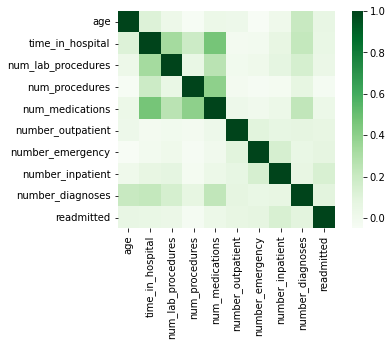

In [ ]:
# Checking correlation among numerical variables and target variable readmitted
correlation_matrix = df3.select('age','time_in_hospital','num_lab_procedures','num_procedures','num_medications','number_outpatient',
                              'number_emergency','number_inpatient','number_diagnoses','readmitted')

pandas_correlation = correlation_matrix.toPandas()
print(pandas_correlation.corr())
#cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(pandas_correlation.corr(),square=True,cmap="Greens")

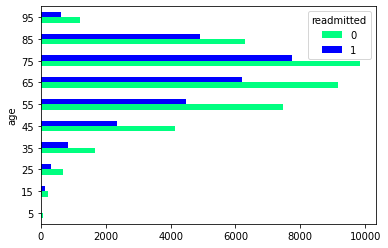

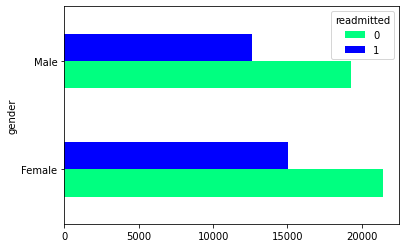

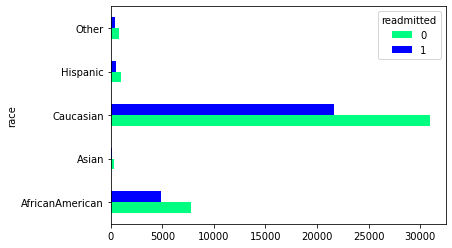

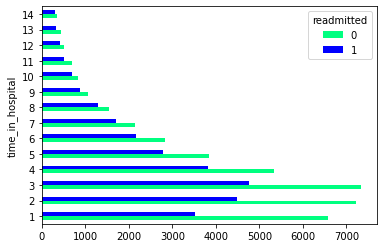

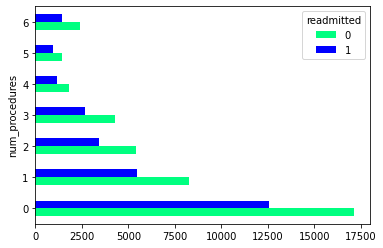

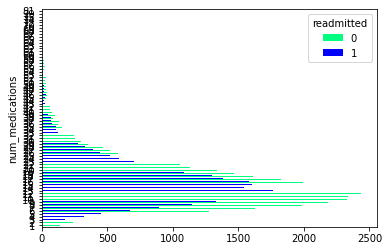

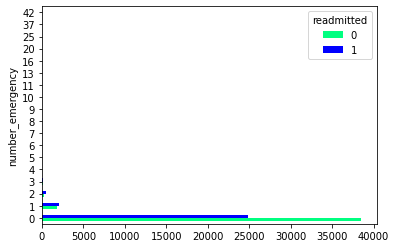

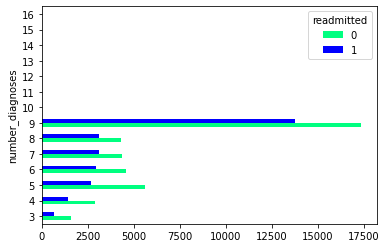

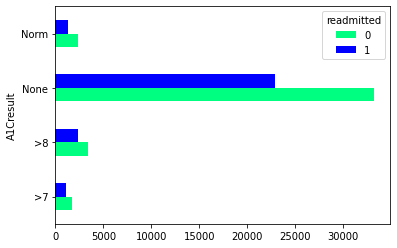

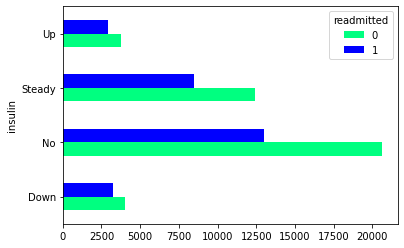

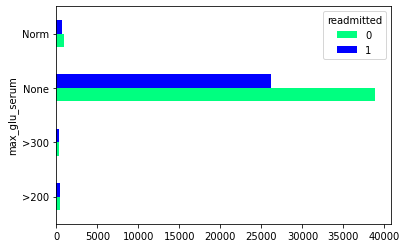

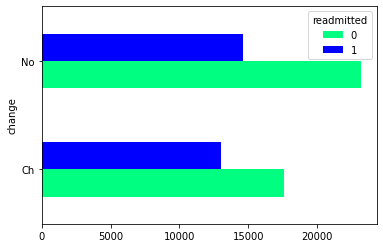

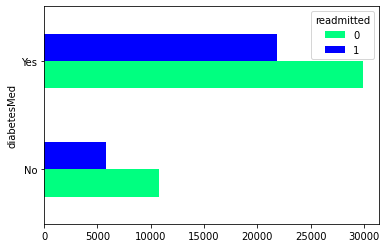

In [ ]:
# Grouped Bar Graph with age and Readmitted
df4 = df3.toPandas().groupby(['age', 'readmitted'])['age'].count().unstack('readmitted')
df4[[0,1]].plot(kind='barh',colormap='winter_r', stacked=False)

# Grouped Bar Graph with gender and Readmitted
df4 = df3.toPandas().groupby(['gender', 'readmitted'])['gender'].count().unstack('readmitted')
df4[[0,1]].plot(kind='barh',colormap='winter_r', stacked=False)

# Grouped Bar Graph with race and Readmitted
df4 = df3.toPandas().groupby(['race', 'readmitted'])['race'].count().unstack('readmitted')
df4[[0,1]].plot(kind='barh',colormap='winter_r', stacked=False)

# Grouped Bar Graph with time_in_hospital and Readmitted
df4 = df3.toPandas().groupby(['time_in_hospital', 'readmitted'])['time_in_hospital'].count().unstack('readmitted')
df4[[0,1]].plot(kind='barh',colormap='winter_r', stacked=False)

# Grouped Bar Graph with num_procedures and Readmitted
df4 = df3.toPandas().groupby(['num_procedures', 'readmitted'])['num_procedures'].count().unstack('readmitted')
df4[[0,1]].plot(kind='barh',colormap='winter_r', stacked=False)

# Grouped Bar Graph with num_medications and Readmitted
df4 = df3.toPandas().groupby(['num_medications', 'readmitted'])['num_medications'].count().unstack('readmitted')
df4[[0,1]].plot(kind='barh',colormap='winter_r', stacked=False)

# Grouped Bar Graph with number of emergency and Readmitted
df4 = df3.toPandas().groupby(['number_emergency', 'readmitted'])['number_emergency'].count().unstack('readmitted')
df4[[0,1]].plot(kind='barh',colormap='winter_r', stacked=False)

# Grouped Bar Graph with Number of diagnoses and Readmitted
df4 = df3.toPandas().groupby(['number_diagnoses', 'readmitted'])['number_diagnoses'].count().unstack('readmitted')
df4[[0,1]].plot(kind='barh',colormap='winter_r', stacked=False)

# Grouped Bar Graph with A1Cresult and Readmitted
df4 = df3.toPandas().groupby(['A1Cresult', 'readmitted'])['A1Cresult'].count().unstack('readmitted')
df4[[0,1]].plot(kind='barh',colormap='winter_r', stacked=False)

# Grouped Bar Graph with Insulin and Readmitted
df4 = df3.toPandas().groupby(['insulin', 'readmitted'])['insulin'].count().unstack('readmitted')
df4[[0,1]].plot(kind='barh',colormap='winter_r', stacked=False)

# Grouped Bar Graph with max_glu_serum and Readmitted
df4 = df3.toPandas().groupby(['max_glu_serum', 'readmitted'])['max_glu_serum'].count().unstack('readmitted')
df4[[0,1]].plot(kind='barh',colormap='winter_r', stacked=False)

# Grouped Bar Graph with change and Readmitted
df4 = df3.toPandas().groupby(['change', 'readmitted'])['change'].count().unstack('readmitted')
df4[[0,1]].plot(kind='barh',colormap='winter_r', stacked=False)

# Grouped Bar Graph with diabetesMed and Readmitted
df4 = df3.toPandas().groupby(['diabetesMed', 'readmitted'])['diabetesMed'].count().unstack('readmitted')
df4[[0,1]].plot(kind='barh',colormap='winter_r', stacked=False)

# **Feature Engineering**

In [ ]:
# creating categorical, numerical lists of columns after dropping the cols

categorical_cols = ['race', 'gender', 'max_glu_serum', 'A1Cresult',  'insulin', 'change', 'diabetesMed', 'admission_source_id', 'admission_type_id', 'discharge_disposition_id']

numerical_cols = ['age','time_in_hospital','num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient','number_diagnoses']

# Currently unsure what to do with 'diag_1','diag_2', 'diag_3' cols
# In cat cols, 'max_glu_serum', 'change', 'diabetesMed' has also been included. Need to see if they are also needed.
# In num cols, need to see if 'number_inpatient', 'number_outpatient' are also needed.

In [ ]:
#print('Total number of features:', len(numerical_cols + categorical_cols))
print('Numerical Features:',len(numerical_cols))
print('Categorical Features:',len(categorical_cols))

Numerical Features: 9
Categorical Features: 10


Creating Dummy variables for nominal categorical columns

In [ ]:
# Creating dummy variables for admission_type_id
df3 = df3.withColumn('admn_type_emergency',fn.when(fn.col('admission_type_id')==1,1).otherwise(0))
df3 = df3.withColumn('admn_type_urgent',fn.when(fn.col('admission_type_id')==2,1).otherwise(0))
df3= df3.withColumn('admn_type_elective',fn.when(fn.col('admission_type_id')==3,1).otherwise(0))
df3 = df3.withColumn('admn_type_trauma',fn.when(fn.col('admission_type_id')==7,1).otherwise(0))

In [ ]:
# Creating dummy variables for discharge_disposition_id
df3 = df3.withColumn('discharge_disp_home',fn.when(fn.col('discharge_disposition_id')==1,1).otherwise(0))
df3 = df3.withColumn('discharge_disp_shortm_hos',fn.when(fn.col('discharge_disposition_id')==2,1).otherwise(0))
df3 = df3.withColumn('discharge_disp_snf',fn.when(fn.col('discharge_disposition_id')==3,1).otherwise(0))
df3 = df3.withColumn('discharge_disp_icf',fn.when(fn.col('discharge_disposition_id')==4,1).otherwise(0))
df3 = df3.withColumn('discharge_disp_careInst',fn.when(fn.col('discharge_disposition_id')==5,1).otherwise(0))
df3 = df3.withColumn('discharge_disp_hhs',fn.when(fn.col('discharge_disposition_id')==6,1).otherwise(0))
df3 = df3.withColumn('discharge_disp_ama',fn.when(fn.col('discharge_disposition_id')==7,1).otherwise(0))
df3 = df3.withColumn('discharge_disp_homeIvy',fn.when(fn.col('discharge_disposition_id')==8,1).otherwise(0))
df3 = df3.withColumn('discharge_disp_admInp',fn.when(fn.col('discharge_disposition_id')==9,1).otherwise(0))
df3 = df3.withColumn('discharge_disp_expired',fn.when(fn.col('discharge_disposition_id')==11,1).otherwise(0))
df3 = df3.withColumn('discharge_disp_hospice',fn.when(fn.col('discharge_disposition_id')==13,1).otherwise(0))
df3 = df3.withColumn('discharge_disp_medfac',fn.when(fn.col('discharge_disposition_id')==14,1).otherwise(0))
df3 = df3.withColumn('discharge_disp_swingbed',fn.when(fn.col('discharge_disposition_id')==15,1).otherwise(0))
df3 = df3.withColumn('discharge_disp_rehab',fn.when(fn.col('discharge_disposition_id')==22,1).otherwise(0))
df3 = df3.withColumn('discharge_disp_long',fn.when(fn.col('discharge_disposition_id')==23,1).otherwise(0))
df3 = df3.withColumn('discharge_disp_nursing',fn.when(fn.col('discharge_disposition_id')==24,1).otherwise(0))
df3 = df3.withColumn('discharge_disp_federal',fn.when(fn.col('discharge_disposition_id')==27,1).otherwise(0))
df3 = df3.withColumn('discharge_disp_psy',fn.when(fn.col('discharge_disposition_id')==28,1).otherwise(0))

In [ ]:
# Creating dummy variables for admission_source_id
df3 = df3.withColumn('admn_source_phyref',fn.when(fn.col('admission_source_id')==1,1).otherwise(0))
df3 = df3.withColumn('admn_source_cliref',fn.when(fn.col('admission_source_id')==2,1).otherwise(0))
df3 = df3.withColumn('admn_source_hmoref',fn.when(fn.col('admission_source_id')==3,1).otherwise(0))
df3 = df3.withColumn('admn_source_hos',fn.when(fn.col('admission_source_id')==4,1).otherwise(0))
df3 = df3.withColumn('admn_source_snf',fn.when(fn.col('admission_source_id')==5,1).otherwise(0))
df3 = df3.withColumn('admn_source_hlthcare',fn.when(fn.col('admission_source_id')==6,1).otherwise(0))
df3 = df3.withColumn('admn_source_emergency',fn.when(fn.col('admission_source_id')==7,1).otherwise(0))
df3 = df3.withColumn('admn_source_court',fn.when(fn.col('admission_source_id')==8,1).otherwise(0))
df3 = df3.withColumn('admn_source_critical',fn.when(fn.col('admission_source_id')==10,1).otherwise(0))
df3 = df3.withColumn('admn_source_normdel',fn.when(fn.col('admission_source_id')==11,1).otherwise(0))
df3 = df3.withColumn('admn_source_birth',fn.when(fn.col('admission_source_id')==14,1).otherwise(0))
df3 = df3.withColumn('admn_source_surgery',fn.when(fn.col('admission_source_id')==25,1).otherwise(0))

In [ ]:
# Creating dummy variables for race
df3 = df3.withColumn('rc_AfricanAmerican',fn.when(fn.col('race')=='AfricanAmerican',1).otherwise(0))
df3 = df3.withColumn('rc_Asian',fn.when(fn.col('race')=='Asian',1).otherwise(0))
df3 = df3.withColumn('rc_Caucasian',fn.when(fn.col('race')=='Caucasian',1).otherwise(0))
df3 = df3.withColumn('rc_Hispanic',fn.when(fn.col('race')=='Hispanic',1).otherwise(0))

In [ ]:
# Creating dummy variables for gender
df3 = df3.withColumn('gender_male',fn.when(fn.col('gender')=='Male',1).otherwise(0))

In [ ]:
# Grouped all the different types of diganosis based on their diag values specificed by the mapping document(ICD codes)
# Created dummy variables for each category

df3 = df3.withColumn('diag1_Circulatory',
fn.when((df3['diag_1'] >= 390) & (df3['diag_1'] <= 459) | (df3['diag_1'] == 785), 1).otherwise(0))

df3 = df3.withColumn('diag1_Respiratory',
fn.when((df3['diag_1'] >= 460) & (df3['diag_1'] <= 519) | (df3['diag_1'] == 786), 1).otherwise(0))

df3 = df3.withColumn('diag1_Digestive',
fn.when((df3['diag_1'] >= 520) & (df3['diag_1'] <= 579) | (df3['diag_1'] == 787), 1).otherwise(0))

df3 = df3.withColumn('diag1_Diabetes',
fn.when((df3['diag_1'] >= 250.00) & (df3['diag_1'] <= 250.99), 1).otherwise(0))

df3 = df3.withColumn('diag1_Injury',
fn.when((df3['diag_1'] >= 800) & (df3['diag_1'] <= 999), 1).otherwise(0))

df3 = df3.withColumn('diag1_Musculoskeletal',
fn.when((df3['diag_1'] >= 710) & (df3['diag_1'] <= 739), 1).otherwise(0))

df3 = df3.withColumn('diag1_Genitourinary',
fn.when((df3['diag_1'] >= 580) & (df3['diag_1'] <= 629) | (df3['diag_1'] == 788), 1).otherwise(0))


df3 = df3.withColumn('diag1_Neoplasms',
fn.when(((df3['diag_1'] >= 1) & (df3['diag_1'] <= 249)) | (df3['diag_1'] == 780) |
    (df3['diag_1'] == 781) | (df3['diag_1'] == 782) | (df3['diag_1'] == 784) |
        ((df3['diag_1'] >= 251) & (df3['diag_1'] <= 279)) |
        ((df3['diag_1'] >= 680) & (df3['diag_1'] <= 709)) |
        ((df3['diag_1'] >= 790) & (df3['diag_1'] <= 799)), 1).otherwise(0))


In [ ]:
# Creating dummy variables for A1Cresult
df3 = df3.withColumn('A1C_7',fn.when(fn.col('A1Cresult')=='>7',1).otherwise(0))
df3 = df3.withColumn('A1C_8',fn.when(fn.col('A1Cresult')=='>8',1).otherwise(0))
df3 = df3.withColumn('A1C_norm',fn.when(fn.col('A1Cresult')=='Norm',1).otherwise(0))

In [ ]:
# Creating dummy variables for max_glu_serum
df3 = df3.withColumn('max_glu_200',fn.when(fn.col('max_glu_serum')=='>200',1).otherwise(0))
df3 = df3.withColumn('max_glu_300',fn.when(fn.col('max_glu_serum')=='>300',1).otherwise(0))
df3 = df3.withColumn('max_glu_norm',fn.when(fn.col('max_glu_serum')=='Norm',1).otherwise(0))
#df3 = df3..select('max_glu_none','max_glu_200','max_glu_300','max_glu_norm').show(10)


In [ ]:
# Creating dummy variables for insulin
df3 = df3.withColumn('insulin_No',fn.when(fn.col('insulin')=='No',1).otherwise(0))
df3 = df3.withColumn('insulin_Up',fn.when(fn.col('insulin')=='Up',1).otherwise(0))
df3 = df3.withColumn('insulin_Steady',fn.when(fn.col('insulin')=='Steady',1).otherwise(0))
df3 = df3.withColumn('insulin_Down',fn.when(fn.col('insulin')=='Down',1).otherwise(0))

In [ ]:
# Creating dummy variables for change and diabetesMed
df3 = df3.withColumn('change',fn.when(fn.col('change')=='Ch',1).otherwise(0))
df3 = df3.withColumn('diabetesMed',fn.when(fn.col('diabetesMed')=='Yes',1).otherwise(0))

In [ ]:
#keeping all created cat dummy variables(columns) and droping others
df3_cat_drop_list = ['race', 'gender', 'max_glu_serum', 'A1Cresult',  'insulin', 'admission_source_id', 'admission_type_id', 'discharge_disposition_id', 'diag_1']
df_final = df3.select([column for column in df3.columns if column not in df3_cat_drop_list])

In [ ]:
df_final.columns

['patient_nbr',
 'age',
 'time_in_hospital',
 'num_lab_procedures',
 'num_procedures',
 'num_medications',
 'number_outpatient',
 'number_emergency',
 'number_inpatient',
 'number_diagnoses',
 'change',
 'diabetesMed',
 'readmitted',
 'admn_type_emergency',
 'admn_type_urgent',
 'admn_type_elective',
 'admn_type_trauma',
 'discharge_disp_home',
 'discharge_disp_shortm_hos',
 'discharge_disp_snf',
 'discharge_disp_icf',
 'discharge_disp_careInst',
 'discharge_disp_hhs',
 'discharge_disp_ama',
 'discharge_disp_homeIvy',
 'discharge_disp_admInp',
 'discharge_disp_expired',
 'discharge_disp_hospice',
 'discharge_disp_medfac',
 'discharge_disp_swingbed',
 'discharge_disp_rehab',
 'discharge_disp_long',
 'discharge_disp_nursing',
 'discharge_disp_federal',
 'discharge_disp_psy',
 'admn_source_phyref',
 'admn_source_cliref',
 'admn_source_hmoref',
 'admn_source_hos',
 'admn_source_snf',
 'admn_source_hlthcare',
 'admn_source_emergency',
 'admn_source_court',
 'admn_source_critical',
 'admn_so

In [ ]:
#shape of dataframe
print((df_final.count(), len(df_final.columns)))

(68357, 70)


# **Modeling**

In [ ]:
#Splitting Data into Training, Validation and Testing

training_df,validation_df,testing_df = df_final.randomSplit([0.6, 0.3, 0.1], seed=0)
print("# training: ", training_df.count())
print("# validation: ", validation_df.count())
print("# testing: ", testing_df.count())

# training:  41101
# validation:  20403
# testing:  6853


In [ ]:
# Checking if training_df split has equal proportion of readmitted patients
training_df.groupBy('readmitted').agg(fn.count('readmitted')).show()

+----------+-----------------+
|readmitted|count(readmitted)|
+----------+-----------------+
|         1|            16673|
|         0|            24428|
+----------+-----------------+



Checking correlation among categorical variables and target variable to select the most important features for logistic regression

                           discharge_disp_home  ...  readmitted
discharge_disp_home                   1.000000  ...   -0.024784
discharge_disp_shortm_hos            -0.192184  ...    0.014003
discharge_disp_snf                   -0.470527  ...    0.037253
discharge_disp_icf                   -0.104754  ...   -0.005640
discharge_disp_careInst              -0.146235  ...    0.017100
discharge_disp_hhs                   -0.462118  ...    0.046457
discharge_disp_ama                   -0.096184  ...   -0.004275
discharge_disp_homeIvy               -0.041725  ...   -0.000382
discharge_disp_admInp                -0.015229  ...   -0.001780
discharge_disp_expired               -0.159386  ...   -0.104480
discharge_disp_hospice               -0.078292  ...   -0.039311
discharge_disp_medfac                -0.072349  ...   -0.040498
discharge_disp_swingbed              -0.029822  ...    0.016070
discharge_disp_rehab                 -0.182927  ...    0.027538
discharge_disp_long                  -0.

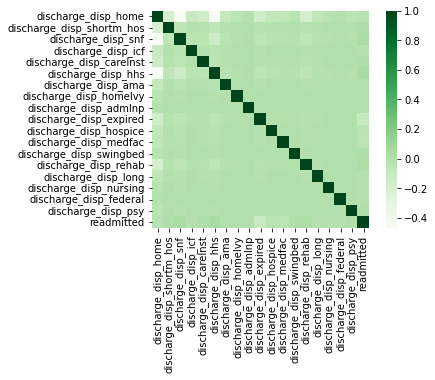

In [ ]:
#  Checking correlation among categorical variables and target variable to select the most important features for logistic regression
correlation_matrix =training_df.select( 'discharge_disp_home', 'discharge_disp_shortm_hos','discharge_disp_snf','discharge_disp_icf','discharge_disp_careInst','discharge_disp_hhs','discharge_disp_ama','discharge_disp_homeIvy','discharge_disp_admInp','discharge_disp_expired','discharge_disp_hospice','discharge_disp_medfac','discharge_disp_swingbed','discharge_disp_rehab', 'discharge_disp_long','discharge_disp_nursing','discharge_disp_federal','discharge_disp_psy','readmitted').toPandas().corr()
print(correlation_matrix)
sns.heatmap(correlation_matrix,square=True,cmap="Greens")
# Only discharge_disp_hhs and discharge_disp_expired are highly correlated with readmitted

               change  diabetesMed  readmitted
change       1.000000     0.506636    0.038982
diabetesMed  0.506636     1.000000    0.067006
readmitted   0.038982     0.067006    1.000000


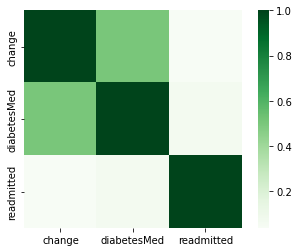

In [ ]:

correlation_matrix=training_df.select('change','diabetesMed','readmitted').toPandas().corr()
print(correlation_matrix)
sns.heatmap(correlation_matrix,square=True,cmap="Greens")
# DiabetesMed is significantly correlated with target variable

                       admn_source_phyref  ...  readmitted
admn_source_phyref               1.000000  ...   -0.031761
admn_source_cliref              -0.074171  ...   -0.012421
admn_source_hmoref              -0.029309  ...    0.002864
admn_source_hos                 -0.124538  ...   -0.048415
admn_source_snf                 -0.060163  ...   -0.009311
admn_source_hlthcare            -0.099416  ...   -0.047318
admn_source_emergency           -0.721072  ...    0.054562
admn_source_court               -0.008019  ...   -0.005881
admn_source_critical            -0.006548  ...   -0.003128
admn_source_normdel                   NaN  ...         NaN
admn_source_birth               -0.004630  ...   -0.005763
admn_source_surgery             -0.004630  ...   -0.005763
readmitted                      -0.031761  ...    1.000000

[13 rows x 13 columns]


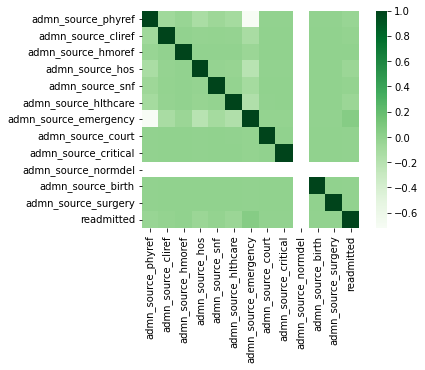

In [ ]:
correlation_matrix=training_df.select('admn_source_phyref', 'admn_source_cliref', 'admn_source_hmoref','admn_source_hos','admn_source_snf','admn_source_hlthcare','admn_source_emergency','admn_source_court','admn_source_critical','admn_source_normdel','admn_source_birth','admn_source_surgery', 'readmitted' ).toPandas().corr()
print(correlation_matrix)
sns.heatmap(correlation_matrix,square=True,cmap="Greens")
#admission_source_emergency is significantly correlated

                       diag1_Neoplasms  ...  readmitted
diag1_Neoplasms               1.000000  ...   -0.022530
diag1_Genitourinary          -0.092977  ...   -0.008588
diag1_Musculoskeletal        -0.098448  ...   -0.015291
diag1_Injury                 -0.108114  ...   -0.009946
diag1_Diabetes               -0.115727  ...    0.023240
diag1_Digestive              -0.127960  ...   -0.008779
diag1_Respiratory            -0.160509  ...    0.013475
diag1_Circulatory            -0.271281  ...    0.020692
readmitted                   -0.022530  ...    1.000000

[9 rows x 9 columns]


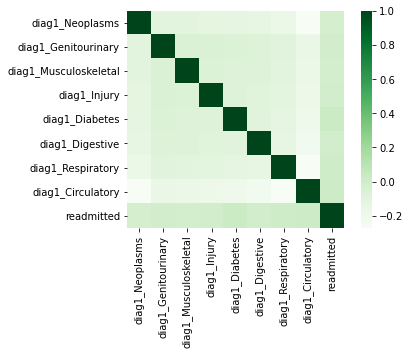

In [ ]:
correlation_matrix=training_df.select('diag1_Neoplasms','diag1_Genitourinary','diag1_Musculoskeletal','diag1_Injury','diag1_Diabetes','diag1_Digestive','diag1_Respiratory','diag1_Circulatory','readmitted' ).toPandas().corr()
print(correlation_matrix)
sns.heatmap(correlation_matrix,square=True,cmap="Greens")

#None of the diagnosis is significantly correlated

                     admn_type_emergency  ...  readmitted
admn_type_emergency             1.000000  ...    0.007656
admn_type_urgent               -0.474642  ...    0.005791
admn_type_elective             -0.505718  ...   -0.050181
admn_type_trauma               -0.019551  ...   -0.015786
readmitted                      0.007656  ...    1.000000

[5 rows x 5 columns]


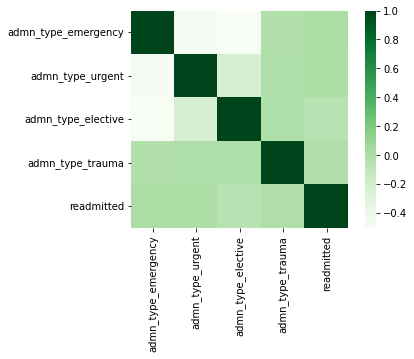

In [ ]:
correlation_matrix=training_df.select('admn_type_emergency','admn_type_urgent','admn_type_elective', 'admn_type_trauma','readmitted' ).toPandas().corr()
print(correlation_matrix)
sns.heatmap(correlation_matrix,square=True,cmap="Greens")
#None of the adminision type is correlated

                insulin_No  insulin_Up  ...  insulin_Down  readmitted
insulin_No        1.000000   -0.323287  ...     -0.337824   -0.036088
insulin_Up       -0.323287    1.000000  ...     -0.112631    0.023202
insulin_Steady   -0.652489   -0.217540  ...     -0.227322    0.005492
insulin_Down     -0.337824   -0.112631  ...      1.000000    0.028139
readmitted       -0.036088    0.023202  ...      0.028139    1.000000

[5 rows x 5 columns]


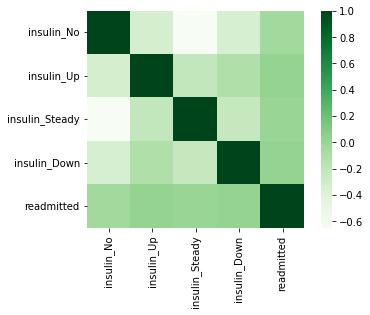

In [ ]:
correlation_matrix=training_df.select('insulin_No',
 'insulin_Up','insulin_Steady', 'insulin_Down','readmitted').toPandas().corr()
print(correlation_matrix)
sns.heatmap(correlation_matrix,square=True,cmap="Greens")
# insulin_No, insulin_Up and insulin_down are significantly correlated with target variable

                         age  time_in_hospital  ...  number_diagnoses  readmitted
age                 1.000000          0.115789  ...          0.209077    0.053931
time_in_hospital    0.115789          1.000000  ...          0.221756    0.055726
num_lab_procedures  0.030249          0.330312  ...          0.153114    0.045527
num_procedures     -0.039837          0.181814  ...          0.072145   -0.031230
num_medications     0.028603          0.458919  ...          0.230886    0.032056
number_outpatient   0.020063         -0.017587  ...          0.070505    0.061965
number_emergency   -0.052892         -0.010742  ...          0.048831    0.073375
number_inpatient    0.016382          0.065565  ...          0.064160    0.141347
number_diagnoses    0.209077          0.221756  ...          1.000000    0.100654
readmitted          0.053931          0.055726  ...          0.100654    1.000000

[10 rows x 10 columns]


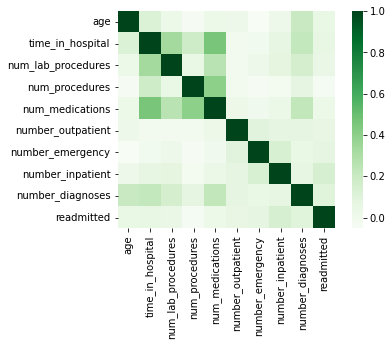

In [ ]:
correlation_matrix=training_df.select('age','time_in_hospital','num_lab_procedures','num_procedures','num_medications','number_outpatient',
                              'number_emergency','number_inpatient','number_diagnoses','readmitted' ).toPandas().corr()
print(correlation_matrix)
sns.heatmap(correlation_matrix,square=True,cmap="Greens")
#almost all are somewhat related to target variable 'readmitted'

              max_glu_200  max_glu_300  max_glu_norm  readmitted
max_glu_200      1.000000    -0.012826     -0.018790    0.012001
max_glu_300     -0.012826     1.000000     -0.016691    0.014639
max_glu_norm    -0.018790    -0.016691      1.000000    0.007807
readmitted       0.012001     0.014639      0.007807    1.000000


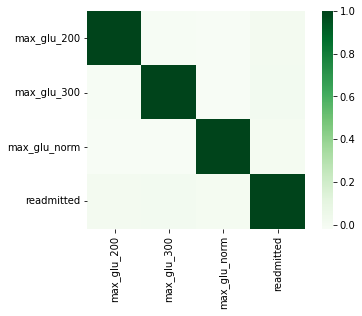

In [ ]:
correlation_matrix=training_df.select('max_glu_200','max_glu_300','max_glu_norm','readmitted' ).toPandas().corr()
print(correlation_matrix)
sns.heatmap(correlation_matrix,square=True,cmap="Greens")
#none of the feature related to target variable 'readmitted'

In [ ]:
#For classification Models
!pip install git+https://github.com/daniel-acuna/pyspark_pipes.git
from pyspark_pipes import pipe

  Cloning https://github.com/daniel-acuna/pyspark_pipes.git to /tmp/pip-req-build-ol4iq0on
  Running command git clone -q https://github.com/daniel-acuna/pyspark_pipes.git /tmp/pip-req-build-ol4iq0on
     |████████████████████████████████| 281.3 MB 47 kB/s 
     |████████████████████████████████| 198 kB 39.0 MB/s 
  Created wheel for pyspark-pipes: filename=pyspark_pipes-0.1-py3-none-any.whl size=3911 sha256=c123a1168add007cae90f22e88e3e9f7d43cddbc54c456a7c95f2934aad119b8
  Stored in directory: /tmp/pip-ephem-wheel-cache-kz5ybjsa/wheels/00/93/7d/817aa49ad2e3d17282ee8dde3a9f738a88e7caae14032bc2ed
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805912 sha256=4a440efe353492423efbdd51bffbe6a85bd579d2514060c8d0848f100fbb9617
  Stored in directory: /root/.cache/pip/wheels/0b/de/d2/9be5d59d7331c6c2a7c1b6d1a4f463ce107332b1ecd4e80718
Successfully built pyspark-pipes pyspark


#Logistic Regression with important features and w/o parameter tuning

In [ ]:
featurelist=['time_in_hospital','number_emergency','number_outpatient','number_inpatient',
                                        'num_medications','number_diagnoses','age','discharge_disp_hhs','discharge_disp_expired','diabetesMed','insulin_No','insulin_Up','insulin_Down','admn_source_emergency']

In [ ]:
lr = Pipeline(stages=[feature.VectorAssembler(inputCols=featurelist,
                                        outputCol='features'),feature.StandardScaler(inputCol='features',outputCol = 'sdfeatures'),
                 classification.LogisticRegression(labelCol='readmitted', featuresCol='sdfeatures')])

In [ ]:
# Fitting the model on training_df
pipe_model =lr.fit(training_df)

In [ ]:
pipe_modeldf = pipe_model.transform(validation_df).select("readmitted","prediction")
pipe_modeldf.show()

+----------+----------+
|readmitted|prediction|
+----------+----------+
|         0|       0.0|
|         0|       0.0|
|         0|       0.0|
|         0|       0.0|
|         0|       0.0|
|         0|       0.0|
|         0|       0.0|
|         1|       0.0|
|         0|       0.0|
|         0|       0.0|
|         0|       0.0|
|         1|       0.0|
|         0|       0.0|
|         0|       0.0|
|         1|       0.0|
|         1|       0.0|
|         1|       0.0|
|         0|       0.0|
|         1|       0.0|
|         0|       0.0|
+----------+----------+
only showing top 20 rows



In [ ]:
# Confusion matrix for logistic regression
tp = pipe_modeldf[(pipe_modeldf.readmitted == 1) & (pipe_modeldf.prediction == 1)].count()
tn = pipe_modeldf[(pipe_modeldf.readmitted == 0) & (pipe_modeldf.prediction == 0)].count()
fp = pipe_modeldf[(pipe_modeldf.readmitted == 0) & (pipe_modeldf.prediction == 1)].count()
fn = pipe_modeldf[(pipe_modeldf.readmitted == 1) & (pipe_modeldf.prediction == 0)].count()
print ("True Positives:", tp)
print ("True Negatives:", tn)
print ("False Positives:", fp)
print ("False Negatives:", fn)
print ("Total", df_final.count())

r = (tp)/(tp + fn)
print ("Sensitivity (Recall): How sensitive is the classifier to detecting positive instances?", r)
p = float(tp) / (tp + fp)
print ("precision", p)

True Positives: 1688
True Negatives: 10987
False Positives: 1223
False Negatives: 6505
Total 68357
Sensitivity (Recall): How sensitive is the classifier to detecting positive instances? 0.20602953740998414
precision 0.5798694606664376


Looking at the recall value we can say that the model correctly predicts only 20% of readmitted cases (positives)

In [ ]:
#calculate specificity
specificity = tn/(tn+fp)
print("specificity",specificity)

specificity 0.8998361998361999


But the model correctly predicts .89% of people who will not require readmittance correctly.

In [ ]:
from pyspark.ml import evaluation
evaluator = evaluation.BinaryClassificationEvaluator(labelCol='readmitted')
evaluator.evaluate(pipe_model.transform(validation_df))


0.6258116859911068

In [ ]:
# Checking the coefficients
pd.DataFrame(list(zip(featurelist, pipe_model.stages[-1].coefficients.toArray())),
            columns = ['column', 'Coefficients']).sort_values('Coefficients',ascending = False).head(10)

,column,Coefficients
3,number_inpatient,0.301480
5,number_diagnoses,0.151180
9,diabetesMed,0.133622
1,number_emergency,0.120226
13,admn_source_emergency,0.097529
2,number_outpatient,0.095632
6,age,0.091321
0,time_in_hospital,0.052513
10,insulin_No,0.045890
7,discharge_disp_hhs,0.040482


/content/spark-3.2.0-bin-hadoop3.2/python/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


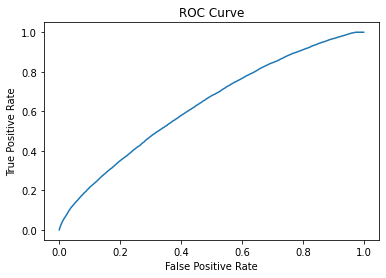

Training set areaUnderROC: 0.6314837086158123


,FPR,TPR
0,0.000000,0.000000
1,0.000205,0.001619
2,0.000287,0.003419
3,0.000696,0.004738
4,0.000982,0.006238
...,...,...
1026,0.996479,1.000000
1027,0.997789,1.000000
1028,0.999099,1.000000
1029,1.000000,1.000000


In [ ]:
trainingSummary = pipe_model.stages[-1].summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))
roc

/content/spark-3.2.0-bin-hadoop3.2/python/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


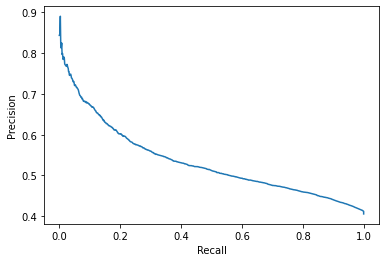

In [ ]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

#Logistic model with Regularization and cross validation

In [ ]:
from pyspark.ml import evaluation


va =feature.VectorAssembler(inputCols=featurelist ,  outputCol='features')
sd = feature.StandardScaler(inputCol='features',outputCol = 'sdfeatures')
# Create initial LogisticRegression model
lr = classification.LogisticRegression(labelCol='readmitted', featuresCol='sdfeatures')
pipe_model2 = Pipeline(stages=[va,sd, lr])
# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.1, 0.3, 0.5]).addGrid(lr.elasticNetParam, [0.2, 0.8, 0.5]).addGrid(lr.maxIter, [15, 30, 50]).build())
# Evaluate model
evaluator = evaluation.BinaryClassificationEvaluator(labelCol='readmitted')
# Create 3-fold CrossValidator
cv = CrossValidator(estimator=pipe_model2,estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=3)

In [ ]:
# Run cross validations and fitting the model on training_df
cvModel = cv.fit(training_df)
# cvModel uses the best model found from the Cross Validation

In [ ]:
#accuracy
evaluator.evaluate(cvModel.transform(validation_df))

0.6137939210806294

In [ ]:
param_dict = cvModel.bestModel.stages[-1].extractParamMap()

sane_dict = {}
for k, v in param_dict.items():
    #print(k)
    sane_dict[k.name] = v

best_reg = sane_dict["regParam"]
best_elastic_net = sane_dict["elasticNetParam"]
best_max_iter = sane_dict["maxIter"]
print(best_reg)
print(best_elastic_net)
print(best_max_iter)

0.1
0.2
50


# Gradient Boosting with Cross-validation and Hyper-parameter tuning

In [ ]:

from pyspark.ml import evaluation


gbt_featlist=['number_inpatient','number_outpatient','time_in_hospital','number_emergency','num_procedures','num_lab_procedures','num_medications','number_diagnoses','age','admn_source_phyref','admn_source_cliref',
'admn_source_hmoref','admn_source_hos','admn_source_snf','admn_source_hlthcare','admn_source_emergency', 'admn_source_court', 'admn_source_critical',
'admn_source_normdel', 'admn_source_birth', 'admn_source_surgery','rc_AfricanAmerican','rc_Asian','rc_Caucasian','rc_Hispanic','discharge_disp_home','discharge_disp_shortm_hos','discharge_disp_snf','discharge_disp_icf','discharge_disp_careInst','discharge_disp_hhs','discharge_disp_ama','discharge_disp_homeIvy','discharge_disp_admInp','discharge_disp_expired',
'discharge_disp_hospice','discharge_disp_medfac','discharge_disp_swingbed','discharge_disp_rehab','discharge_disp_long','discharge_disp_nursing','discharge_disp_federal','discharge_disp_psy','diag1_Circulatory','diag1_Respiratory','diag1_Digestive','diag1_Diabetes','diag1_Injury','diag1_Musculoskeletal','diag1_Genitourinary','diag1_Neoplasms',
'max_glu_200','max_glu_300','max_glu_norm','A1C_7','A1C_8','A1C_norm', 'insulin_No','insulin_Up','insulin_Steady','insulin_Down']

va =feature.VectorAssembler(inputCols= gbt_featlist ,  outputCol='features')
sd = feature.StandardScaler(inputCol='features',outputCol = 'sdfeatures')
gbt = classification.GBTClassifier(labelCol='readmitted', featuresCol='sdfeatures')
GBT_model_pipeline  = Pipeline(stages=[va,sd,gbt])

paramGrid = ParamGridBuilder().addGrid(gbt.maxDepth, [4, 6]).addGrid(gbt.maxBins, [20, 40]).addGrid(gbt.maxIter, [10, 20]) .build()


evaluator = evaluation.BinaryClassificationEvaluator(labelCol='readmitted')

cv = CrossValidator(estimator=GBT_model_pipeline,estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=3)

In [ ]:
cvModel_gbt = cv.fit(training_df)

In [ ]:
predictions_gbt = cvModel_gbt.transform(validation_df)
predictions_gbt = predictions_gbt.withColumn('label',predictions_gbt.readmitted)

In [ ]:
#accuracy
evaluator.evaluate(predictions_gbt)

0.6439470711349141

In [ ]:
# Confusion matrix for GBT
tp = predictions_gbt[(predictions_gbt.readmitted == 1) & (predictions_gbt.prediction == 1)].count()
tn = predictions_gbt[(predictions_gbt.readmitted == 0) & (predictions_gbt.prediction == 0)].count()
fp = predictions_gbt[(predictions_gbt.readmitted == 0) & (predictions_gbt.prediction == 1)].count()
fn = predictions_gbt[(predictions_gbt.readmitted == 1) & (predictions_gbt.prediction == 0)].count()
print ("True Positives:", tp)
print ("True Negatives:", tn)
print ("False Positives:", fp)
print ("False Negatives:", fn)


True Positives: 2299
True Negatives: 10559
False Positives: 1651
False Negatives: 5894


In [ ]:
# Important features by gradient boosting
gbt_model = cvModel_gbt.bestModel.stages[-1]
feature_importance=pd.DataFrame(list(zip(['number_inpatient','number_outpatient','time_in_hospital','number_emergency','num_procedures','num_lab_procedures',
                                          'num_medications','number_diagnoses','age','admn_source_phyref','admn_source_cliref','admn_source_hmoref','admn_source_hos',
                                         'admn_source_snf','admn_source_hlthcare','admn_source_emergency', 'admn_source_court', 'admn_source_critical','admn_source_normdel',
                                          'admn_source_birth', 'admn_source_surgery','rc_AfricanAmerican','rc_Asian','rc_Caucasian','rc_Hispanic','discharge_disp_home','discharge_disp_shortm_hos',
                                          'discharge_disp_snf',
                                          'discharge_disp_icf','discharge_disp_careInst','discharge_disp_hhs','discharge_disp_ama','discharge_disp_homeIvy','discharge_disp_admInp','discharge_disp_expired',
                                          'discharge_disp_hospice','discharge_disp_medfac','discharge_disp_swingbed','discharge_disp_rehab','discharge_disp_long','discharge_disp_nursing','discharge_disp_federal',
                                          'discharge_disp_psy','diag1_Circulatory','diag1_Respiratory','diag1_Digestive','diag1_Diabetes','diag1_Injury','diag1_Musculoskeletal','diag1_Genitourinary',
                                          'diag1_Neoplasms','max_glu_200','max_glu_300','max_glu_norm','A1C_7','A1C_8','A1C_norm', 'insulin_No','insulin_Up',
                                          'insulin_Steady','insulin_Down'], gbt_model.featureImportances.toArray())),
columns = ['feature', 'importance']).sort_values('importance', ascending=False)
feature_importance.head(10)


,feature,importance
34,discharge_disp_expired,0.091431
8,age,0.084874
6,num_medications,0.081213
7,number_diagnoses,0.063362
0,number_inpatient,0.063048
2,time_in_hospital,0.056256
5,num_lab_procedures,0.055299
36,discharge_disp_medfac,0.045702
4,num_procedures,0.042423
35,discharge_disp_hospice,0.039023


# Model Comparison based on Accuracy and False Negatives

Text(0.5, 1.0, 'Model Comparison based on Accuracy')

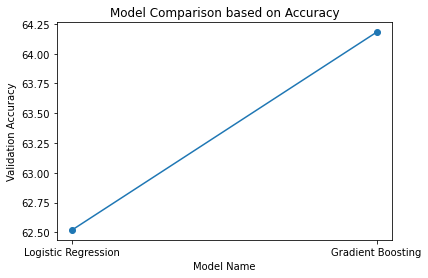

In [ ]:
# for health care domain, we compare our models based on False Negatives and accuracy.
# In this project we consider the model with the least FN and highest accuracy is the best model.

model_comparison_df = pd.DataFrame({'Model_name': ['Logistic Regression','Gradient Boosting'],
                                   'Validation_Accuracy': [62.52,64.18],
                                   'False_Negatives': [6521,5873]})

plt.plot(model_comparison_df.Model_name,model_comparison_df.Validation_Accuracy,'-o')
plt.xlabel('Model Name')
plt.ylabel('Validation Accuracy')
plt.title('Model Comparison based on Accuracy')

Text(0.5, 1.0, 'Model Comparison based on False Negatives')

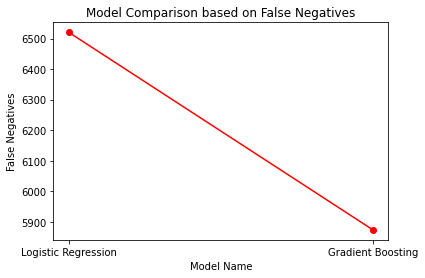

In [ ]:
plt.plot(model_comparison_df.Model_name,model_comparison_df.False_Negatives,'-or')
plt.xlabel('Model Name')
plt.ylabel('False Negatives')
plt.title('Model Comparison based on False Negatives')

From the above graphs we can see that Gradient Boosting has the maximum accuracy on Validation set and least False Negatives.

In [ ]:
#Testing Gradient Boosting on test dataset

predictions_gbt_test = cvModel_gbt.transform(testing_df)
predictions_gbt_test = predictions_gbt_test.withColumn('prediction',predictions_gbt_test.prediction)

predictions_gbt_test = predictions_gbt_test.withColumn('label',predictions_gbt_test.readmitted)
evaluator.evaluate(predictions_gbt_test)

0.6468950071101982

In [ ]:
# Confusion matrix for GBT with testing dataset
tp =predictions_gbt_test[(predictions_gbt_test.readmitted == 1) & (predictions_gbt_test.prediction == 1)].count()
tn = predictions_gbt_test[(predictions_gbt_test.readmitted == 0) & (predictions_gbt_test.prediction == 0)].count()
fp =predictions_gbt_test[(predictions_gbt_test.readmitted == 0) & (predictions_gbt_test.prediction == 1)].count()
fn = predictions_gbt_test[(predictions_gbt_test.readmitted == 1) & (predictions_gbt_test.prediction == 0)].count()
print ("True Positives:", tp)
print ("True Negatives:", tn)
print ("False Positives:", fp)
print ("False Negatives:", fn)

r = (tp)/(tp + fn)
print ("recall", r)
p = float(tp) / (tp + fp)
print ("precision", p)

True Positives: 791
True Negatives: 3518
False Positives: 572
False Negatives: 1972
recall 0.2862830256967065
precision 0.5803374908290535


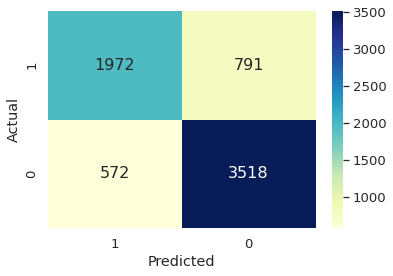

In [ ]:
# Plotting the test set confusion matrix
array = [[3518,572],
     [791,1972]]
df_cm = pd.DataFrame(array, range(2),
                  range(2))
#plt.figure(figsize = (10,7))
sns.set(font_scale=1.2)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16},cmap='YlGnBu',fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

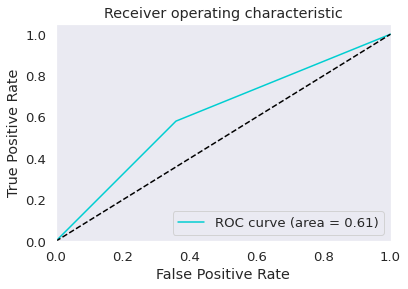

In [ ]:
# Plotting the test set ROC and AUC
predictions_gbt_test_df = predictions_gbt_test.toPandas()
predictions_test = predictions_gbt_test_df['prediction']
outcome_test = predictions_gbt_test_df['label']
fpr, tpr, thresholds = roc_curve(predictions_test, outcome_test)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkturquoise', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.grid(b=False)
plt.show()

# Conclusion

Gradient Boosting performed the best in terms of accuracy and number of false negatives and also fits the testing data well!!